In [1]:
import cv2
from lesson_functions import *
import visialize_funcs as vis_funcs
import time

%matplotlib inline

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time

# Read in our vehicles
car_images = glob.glob('../vehicle_detection/vehicles/*/*.png')
not_car_images = glob.glob('../vehicle_detection/non-vehicles/*/*.png')
np.random.shuffle(car_images)
np.random.shuffle(not_car_images)

In [3]:
color_space = 'YCrCb'
spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # 0,1,2,'ALL'
spatial_feat = True
hist_feat = False
hog_feat = True
example_size = 0.5

In [4]:
# 
def train(color_space, example_size_scale, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
          pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
          hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat) :
    t_before_extrace_feature = time.time()
    my_car_images = car_images[:int(example_size_scale * len(car_images) - 1)]
    my_noncar_images = not_car_images[:int(example_size_scale * len(not_car_images) - 1)]
    car_features = extract_features(my_car_images, color_space, spatial_size, hist_bins, 
                                    orient, pix_per_cell, cell_per_block, hog_channel,
                                    spatial_feat, hist_feat, hog_feat)
    notcar_features = extract_features(my_noncar_images,  color_space, spatial_size, hist_bins, 
                                    orient, pix_per_cell, cell_per_block, hog_channel,
                                    spatial_feat, hist_feat, hog_feat)
    print(round(time.time() - t_before_extrace_feature, 2), 'Seconds to extract features')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    y = np.hstack((np.ones(len(car_features)), 
                   np.zeros(len(notcar_features))))
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    from sklearn.preprocessing import StandardScaler
    t_before_fit = time.time()
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    scaled_X_train = X_scaler.transform(X_train)
    scaled_X_test = X_scaler.transform(X_test)
    print(round(time.time() - t_before_fit, 2), 'Seconds to fit and transform scaler')

    # Use a linear SVC (support vector classifier)
    svc = LinearSVC()
    # Train the SVC
    t=time.time()
    svc.fit(scaled_X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', svc.score(scaled_X_test, y_test))
    return svc, X_scaler

In [7]:
#
def predict(color_space, example_size, hog_channel):    
    clf, scaler = train(color_space, example_size, hog_channel=hog_channel)

    image = mpimg.imread('test_images/test6.jpg')

    t_before_sliding =time.time()

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[200, None], 
                        xy_window=(512, 512), xy_overlap=(0.5, 0.5))

    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 636], 
                        xy_window=(256, 256), xy_overlap=(0.5, 0.5))

    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 636], 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    windows3 = slide_window(image, x_start_stop=[630, 900], y_start_stop=[380, 530], 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    # windows_all = np.concatenate((windows, windows1, windows2, windows3, windows4, windows5))
    windows_all = []
    windows_all.extend(windows)
    windows_all.extend(windows1)
    windows_all.extend(windows2)
    windows_all.extend(windows3)

    t_after_sliding = time.time()
    print(round(t_after_sliding-t_before_sliding, 2), 'Seconds to slide windows...')

    on_windows = search_windows(image, windows_all, clf, scaler, color_space, 
                                hog_channel=hog_channel, hog_feat=hog_feat, 
                                hist_feat=hist_feat, spatial_feat=spatial_feat)
    t_search = time.time()
    print(round(t_search - t_after_sliding, 2), 'Seconds to search windows...')
    print('total:', len(windows_all), ', has car:', len(on_windows))
    window_img = draw_boxes(image, on_windows, color=(0, 0, 255), thick=6)                    
    plt.imshow(window_img)

5.16 Seconds to extract features
0.17 Seconds to fit and transform scaler
4.24 Seconds to train SVC...
Test Accuracy of SVC =  0.943661971831
0.0 Seconds to slide windows...
0.25 Seconds to search windows...
total: 91 , has car: 0


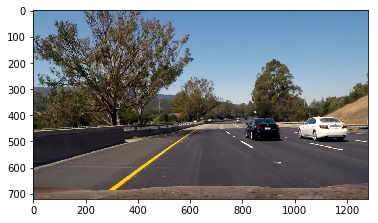

In [8]:
predict(color_space, 0.1, 0)

In [ ]:
predict(color_space, 0.1, 1)

In [ ]:
predict(color_space, 0.1, 2)